In [81]:
#!pip install --upgrade datasets


In [82]:
!rm -rf ~/.cache/huggingface/datasets


In [83]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True, augment=False):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle

        self.indexes = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

        if self.augment:                        # data augmentation with zoom/horizontal flip/ random rotation to 20° and moving the image
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        x_batch = self.x_data[batch_indexes]
        y_batch = self.y_data[batch_indexes]
        return x_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)




In [84]:
from datasets import load_dataset
import numpy as np
ds = load_dataset("enterprise-explorers/oxford-pets");  # name can update from hugging face carefull
image_shape= 224

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

In [85]:
ds_train = ds["train"]
ds

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

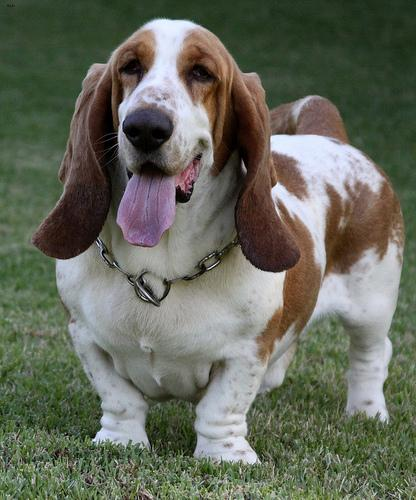

(416, 500)


In [86]:
from PIL import Image
import io
image = ds["train"][4]["image"]
old_Imageshow = image

display(old_Imageshow)
print(old_Imageshow.size)   # size of image is random

In [87]:
def resize_image(example, size=(image_shape, image_shape)):     #convert all iamge to iamge_shape X image_shape pixel using .resize (96x96 for example)

    image = example["image"]

    if image.mode in ['RGBA', 'P', 'L']:
        image = image.convert('RGB')


    image_resized = image.resize(size)
    image_array = np.array(image_resized) / 255.0  # Normalize to [0, 1]

    byte_io = io.BytesIO()
    image_resized.save(byte_io, format='JPEG')
    byte_io.seek(0)


    example["image"] = byte_io.read()

    return example
ds_resize = ds_train.map(resize_image)

Map:   0%|          | 0/7390 [00:00<?, ? examples/s]

(224, 224)
JPEG


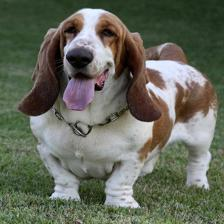

In [88]:
image = ds_resize[4]["image"]
Imageshow = image

print(Imageshow.size)
print(Imageshow.format)
display(Imageshow)      # dataset is resized and named ds_resize

In [89]:
from sklearn.model_selection import train_test_split
images = []
labels = []
isdog = []

for i in range(7390):
    image =ds_resize[i]["image"]

    label = ds_resize[i]["label"]
    dog = ds_resize[i]["dog"]
    images.append(np.array(image))    # cast PIL.image into numpy array
    labels.append(label)
    isdog.append(int(dog))


del ds_resize       # delete the ds_resize after using it so we save memory
gc.collect()


12249

In [90]:
occurrences = {}

for id in labels:
  if id in occurrences:
    occurrences[id] += 1
  else:
    occurrences[id] = 1

print(occurrences)
class_breeds=list(occurrences.keys())
print(list(occurrences.keys()))
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
breed_class= label_encoder.fit_transform(list(occurrences.keys()))
print(breed_class)
print(len(breed_class))
labels = label_encoder.transform(labels)
print(labels)

{'Siamese': 200, 'Birman': 200, 'shiba inu': 200, 'staffordshire bull terrier': 191, 'basset hound': 200, 'Bombay': 200, 'japanese chin': 200, 'chihuahua': 200, 'german shorthaired': 200, 'pomeranian': 200, 'beagle': 200, 'english cocker spaniel': 200, 'american pit bull terrier': 200, 'Ragdoll': 200, 'Persian': 200, 'Egyptian Mau': 200, 'miniature pinscher': 200, 'Sphynx': 200, 'Maine Coon': 200, 'keeshond': 200, 'yorkshire terrier': 200, 'havanese': 200, 'leonberger': 200, 'wheaten terrier': 200, 'american bulldog': 200, 'english setter': 200, 'boxer': 200, 'newfoundland': 200, 'Bengal': 200, 'samoyed': 200, 'British Shorthair': 200, 'great pyrenees': 200, 'Abyssinian': 200, 'pug': 200, 'saint bernard': 200, 'Russian Blue': 200, 'scottish terrier': 199}
['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', '

we can see that animals breed are equally spread so We do not need to normalize

In [91]:
from tensorflow.keras.utils import to_categorical
x = np.array(images, dtype=np.float16) / 255.0
y = np.array(labels, dtype=np.int16)



In [92]:
print(f"x_train shape: {x.shape}")
print(f"y_train shape: {y.shape}")
print(f"x_train dtype: {type(x)}")
print(f"y_train dtype: {y.dtype}")

x_train shape: (7390, 224, 224, 3)
y_train shape: (7390,)
x_train dtype: <class 'numpy.ndarray'>
y_train dtype: int16


In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [94]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_train dtype: {type(x_train)}")
print(f"y_train dtype: {y_train.dtype}")

x_train shape: (5912, 224, 224, 3)
y_train shape: (5912,)
x_train dtype: <class 'numpy.ndarray'>
y_train dtype: int16


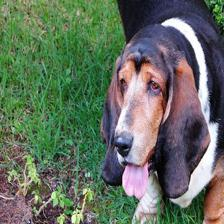

In [95]:
display((Image.fromarray((x_train[4]*255.0).astype('uint8')) )) # this is how you display an image

In [96]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(image_shape, image_shape, 3))

In [97]:
for layer in base_model.layers:
    layer.trainable = False



In [98]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(37, activation='softmax')(x)

In [99]:
batch_size = 16
train_generator = DataGenerator(x_train, y_train, batch_size, augment=True)
test_generator = DataGenerator(x_test, y_test, batch_size, augment=False)

In [100]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,785,125 (56.40 MB)

 Trainable params: 70,437 (275.14 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [101]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_generator, epochs=40, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


369/369 ━━━━━━━━━━━━━━━━━━━━ 54s 130ms/step - accuracy: 0.0323 - loss: 3.7365 - val_accuracy: 0.0469 - val_loss: 3.5806
Epoch 2/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.0402 - loss: 3.5822 - val_accuracy: 0.0870 - val_loss: 3.5276
Epoch 3/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 83s 130ms/step - accuracy: 0.0688 - loss: 3.5193 - val_accuracy: 0.1257 - val_loss: 3.4600
Epoch 4/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - accuracy: 0.0853 - loss: 3.4575 - val_accuracy: 0.1630 - val_loss: 3.3851
Epoch 5/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - accuracy: 0.1119 - loss: 3.3834 - val_accuracy: 0.1698 - val_loss: 3.3084
Epoch 6/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.1191 - loss: 3.3189 - val_accuracy: 0.2079 - val_loss: 3.2211
Epoch 7/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.1407 - loss: 3.2284 - val_accuracy: 0.2317 - val_loss: 3.1415
Epoch 8/40
369/369 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.1389 - loss: 3.1616 - val

In [102]:

for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])


history_finetune = model.fit(train_generator, validation_data=test_generator, epochs=30, callbacks=[early_stopping])


Epoch 1/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 79s 200ms/step - accuracy: 0.4657 - loss: 1.6855 - val_accuracy: 0.6800 - val_loss: 1.0940
Epoch 2/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 73s 198ms/step - accuracy: 0.5990 - loss: 1.2142 - val_accuracy: 0.7154 - val_loss: 0.9439
Epoch 3/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 73s 198ms/step - accuracy: 0.6623 - loss: 1.0262 - val_accuracy: 0.7473 - val_loss: 0.8390
Epoch 4/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 74s 200ms/step - accuracy: 0.6738 - loss: 0.9412 - val_accuracy: 0.7629 - val_loss: 0.7917
Epoch 5/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 73s 198ms/step - accuracy: 0.7343 - loss: 0.8120 - val_accuracy: 0.7541 - val_loss: 0.7956
Epoch 6/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 73s 199ms/step - accuracy: 0.7528 - loss: 0.7125 - val_accuracy: 0.7582 - val_loss: 0.7873
Epoch 7/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 73s 198ms/step - accuracy: 0.7719 - loss: 0.6539 - val_accuracy: 0.7792 - val_loss: 0.7218
Epoch 8/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 73s 198ms/step - accuracy: 0.7989 - loss: 0

In [103]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.8013 - loss: 0.6386
Test Loss: 0.5600929260253906
Test Accuracy: 0.8226901888847351


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


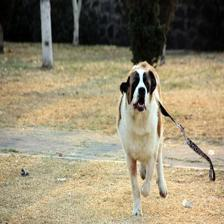

Pred: samoyed
True: samoyed


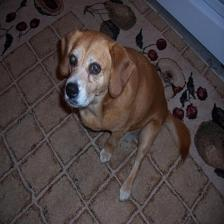

Pred: pomeranian
True: pomeranian


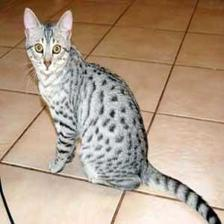

Pred: american bulldog
True: american bulldog


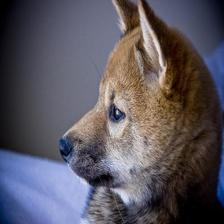

Pred: leonberger
True: leonberger


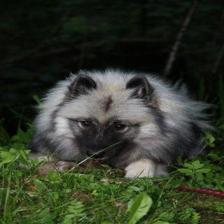

Pred: British Shorthair
True: British Shorthair


In [104]:
import random
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(x_test)), 5)

selected_images = x_test[random_indices]
selected_labels = y_test[random_indices]


predictions = model.predict(selected_images)
predicted_labels = np.argmax(predictions, axis=1)
image=0
for i in random_indices:
    display(Image.fromarray((x_train[i]*255.0).astype('uint8')) )

    print(f"Pred: {class_breeds[predicted_labels[image]]}\nTrue: {class_breeds[y_test[i]]}")
    image+=1



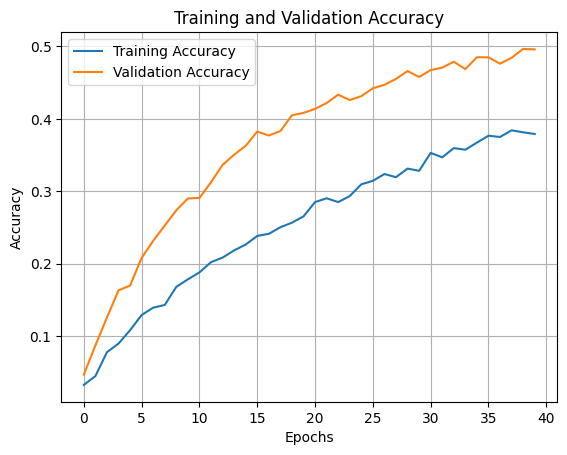

In [105]:
#plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

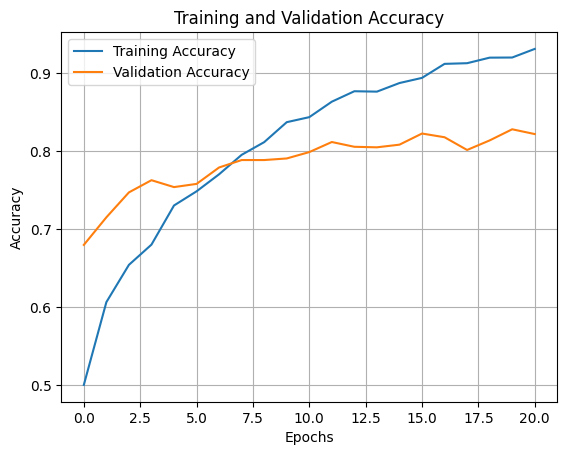

In [106]:
#plot training and validation accuracy
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

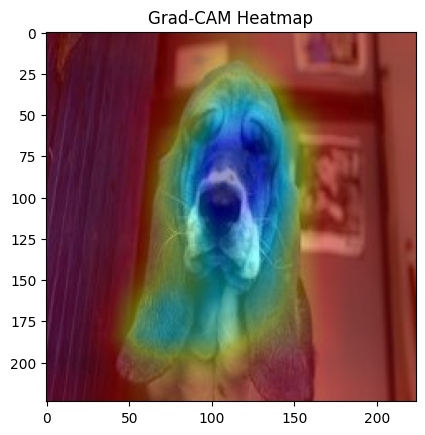

In [107]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Function to apply Grad-CAM
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])  # Predicted class
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    heatmap = np.mean(conv_outputs[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap


def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img


def visualize_gradcam(model, image_array, layer_name="block5_conv3"):

    img = (image_array * 255).astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    img_array = tf.image.resize(img, (224, 224)) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = compute_gradcam(model, img_array, layer_name)

    overlayed_img = overlay_heatmap(img, heatmap)


    plt.imshow(overlayed_img)
    plt.title("Grad-CAM Heatmap")
    plt.show()

visualize_gradcam(model, x_train[15])


In [108]:
#!pip install lime

  0%|          | 0/1000 [00:00<?, ?it/s]

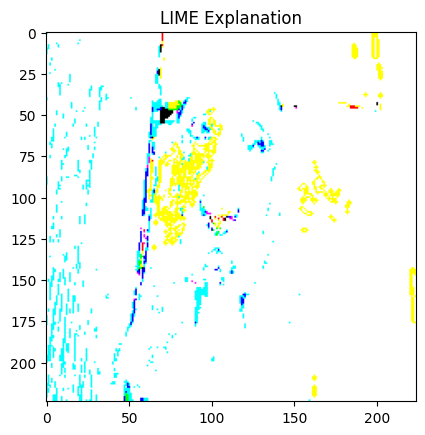

In [109]:
import sys
import os
from lime import lime_image
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import cv2


explainer = lime_image.LimeImageExplainer()

def suppress_lime_output(func):       # this is to avoid having green bar
    with open(os.devnull, 'w') as fnull:
        with redirect_stdout(fnull):
            return func()

# Function to visualize lime explanation
def visualize_lime(model, image_array):
    img = (image_array * 255).astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = tf.image.resize(img, (224, 224)).numpy()


    explanation = suppress_lime_output(lambda: explainer.explain_instance(
        img_resized,
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    ))

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False, )
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")
    plt.show()


visualize_lime(model, x_train[15])


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step


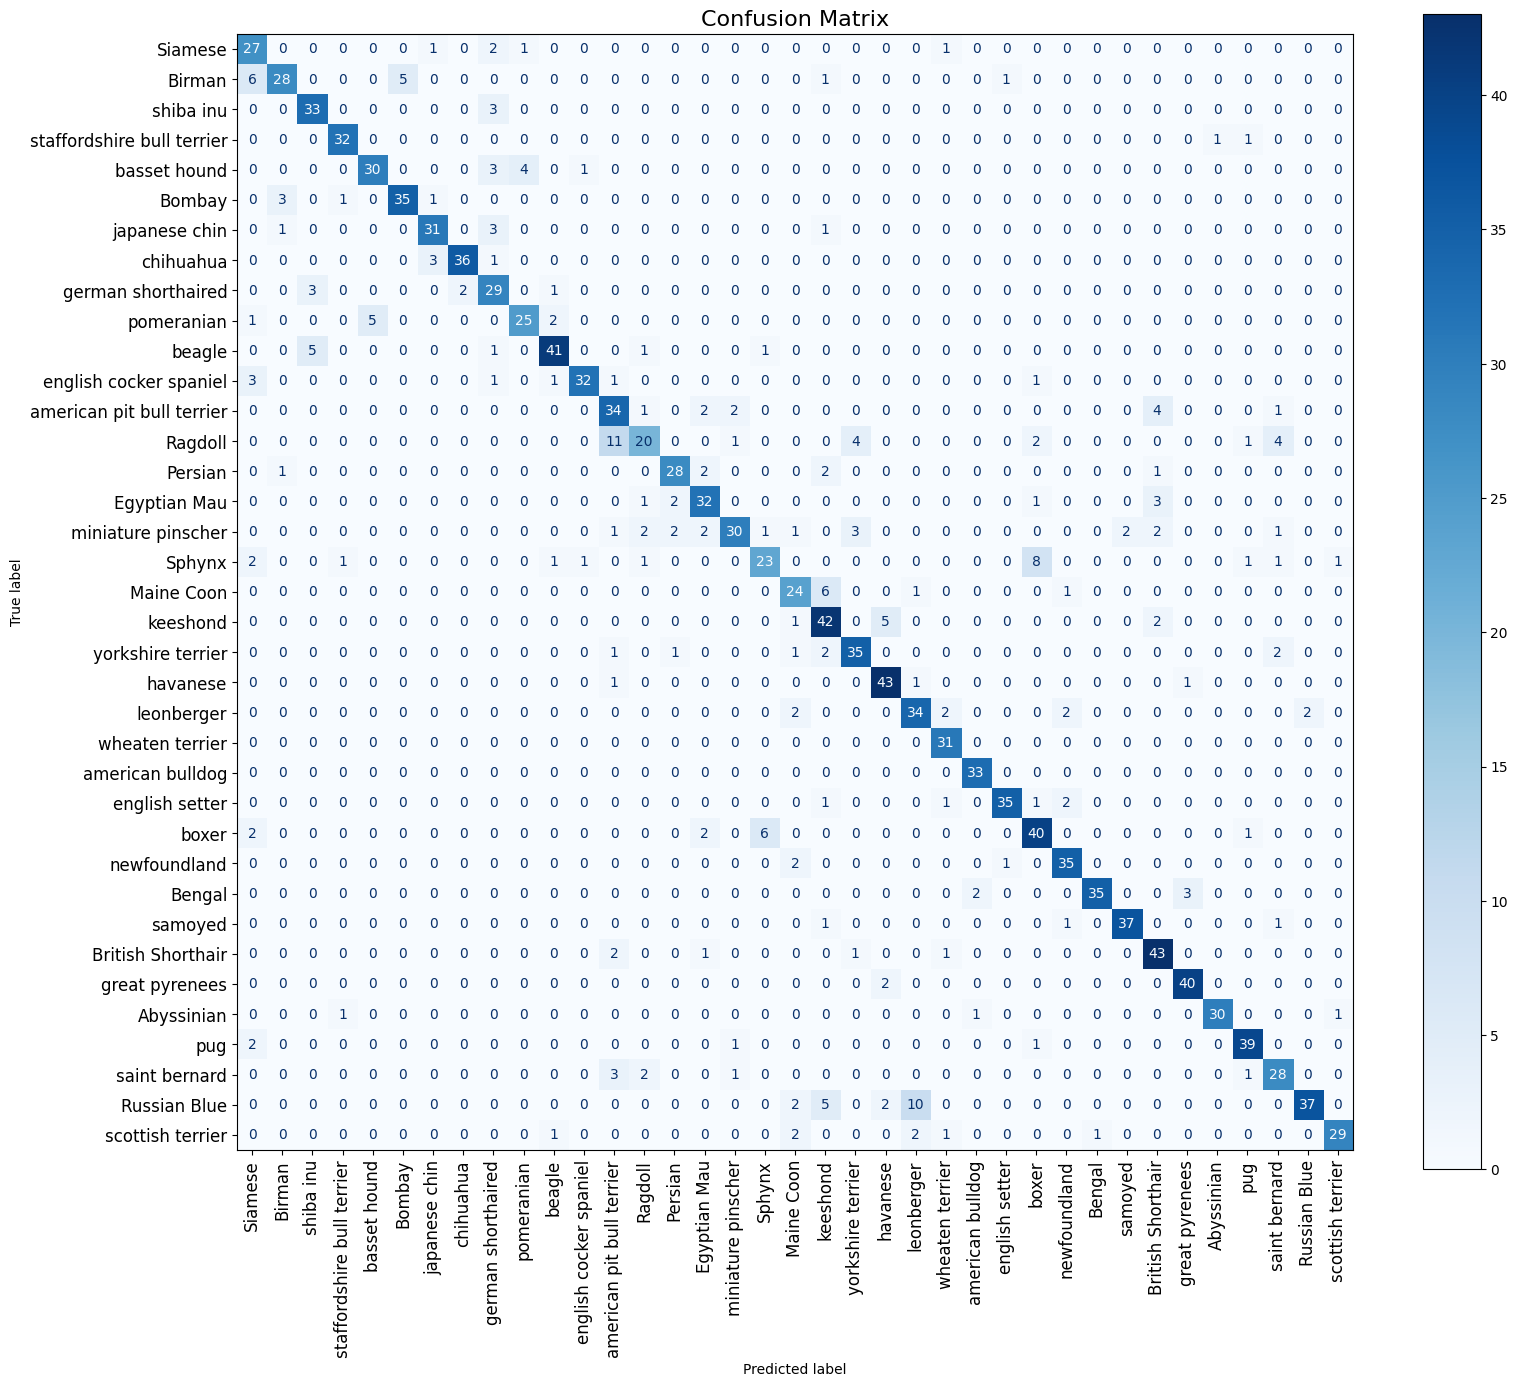

In [112]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# confusion matrix
y_pred = np.argmax(model.predict(x_test), axis=-1)

cm = confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots(figsize=(18, 15))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_breeds)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [113]:
# due to high precision (84%) we can see that there is not so much confusion. We observe some wrong answers (5) between Birman and Siamese breeds, which makes sense given their similar appearance

report :

At first, I had to figure out how to handle the image data and work with byte strings
I found that using PIL worked well and was easy to diplay

I struggled a lot at first because I didn't have a good GPU on Google Colab

My first approach:
-reduced image size to 32x32 pixels
-simplified the model to just one layer
-freed up memory from unused variables
-increased batch size

however model.fit kept crashing so I had to found more tricks

I switched to a data generator as suggested, in order to charge data one batch at the time, this allowed the model to compile, but training was very slow and the accuracy was poor

After upgrading to a T4 GPU on Colab everything improved


-went back to 224x224 pixels which is a better size for VGG
-reduced batch size

The model worked better and trained faster
but overfitted quickly and lacked precision

Fixing :

-I added dropout layer to prevent overfitting
-used data augmentation
-used early stopping when overfitting occurred

the model was performing better but I tried to do more.

Fine-Tuning the Model:
-I then tried unfreezing layers after a few epochs
-lowering the Adam learning rate
-testing different training strategies

The best setup was 40 epochs with frozen layers Unfreeze & fine-tune for 30 more epochs (more like 25 with early stopping)


With this, the model's accuracy jumped to around 80%

after this I did the LIME and Grad-CAM + confusion matrix
to visualize model it was very interesting